# [Azure Machine Learning](https://docs.microsoft.com/en-us/azure/machine-learning/)

## [Quickstart: Create workspace resources you need to get started with Azure Machine Learning](https://docs.microsoft.com/en-us/azure/machine-learning/quickstart-create-resources)

1. Create an azure account -- [Github Student developer pack](https://education.github.com/pack) provides free account with $100 credit
2. Follow ["Create the workspace"](https://docs.microsoft.com/en-us/azure/machine-learning/quickstart-create-resources#create-the-workspace) to start a Azure Machine Learning Studio
3. Follow ["Create compute instance"](https://docs.microsoft.com/en-us/azure/machine-learning/quickstart-create-resources#instance) to create 2 compute instances (don't use the defaults!). Here, you can create a 1-core (Standard_DS1_v2 (1 cores, 3.5 GB RAM, 7 GB disk) and a 4-core (Standard_DS3_v2 (4 cores, 14 GB RAM, 28 GB disk) instance.

## Jupyter notebooks on Azure

1. Download this notebook as a `.ipynb` file to your PC.
2. On the home of Microsoft Azure Machine Learning Studio, you will see a panel with `Notebooks`. Click on `Start now`.
3. Click on `Terminal` and type `pip install git+https://github.com/econ-ark/HARK.git` on both computes. You can switch computes on the top right part of the window.
4. Close and terminate the terminals.
5. Click on `+ Create` and `Upload files`. Upload this notebook.
6. Make sure the kernel is set to `Python 3.8 AzureML` on upper right corner next to compute.

Now, you should be able to run this notebook on either compute (switch computes on top right again) and test out the differences in computational resources. When you run into an issue on your desktop computer or laptop, you can take advantage of cloud computing resources.

# IndShockConsumerTypeFast Documentation
## Consumption-Saving model with Idiosyncratic Income Shocks

In [1]:
# Initial imports and notebook setup, click arrow to show
from HARK.ConsumptionSaving.ConsIndShockModelFast import IndShockConsumerTypeFast
from HARK.utilities import plot_funcs, plot_funcs_der

mystr = lambda number: f"{number:.4f}"

The module `HARK.ConsumptionSaving.ConsIndShockModelFast` concerns consumption-saving models with idiosyncratic shocks to (non-capital) income.  All of the models assume CRRA utility with geometric discounting, no bequest motive, and income shocks are fully transitory or fully permanent.

$\newcommand{\CRRA}{\rho}$
$\newcommand{\DiePrb}{\mathsf{D}}$
$\newcommand{\PermGroFac}{\Gamma}$
$\newcommand{\Rfree}{\mathsf{R}}$
$\newcommand{\DiscFac}{\beta}$

## Statement of idiosyncratic income shocks model

Suppose we want to solve a model like the one analyzed in [BufferStockTheory](https://www.econ2.jhu.edu/people/ccarroll/papers/BufferStockTheory/), which has all the same features as the perfect foresight consumer, plus idiosyncratic shocks to income each period.  Agents with this kind of model are represented by the class `IndShockConsumerTypeFast`.

Specifically, this type of consumer receives two income shocks at the beginning of each period: a completely transitory shock $\newcommand{\tShkEmp}{\theta}{\tShkEmp_t}$ and a completely permanent shock $\newcommand{\pShk}{\psi}{\pShk_t}$.  Moreover, the agent is subject to borrowing a borrowing limit: the ratio of end-of-period assets $A_t$ to permanent income $P_t$ must be greater than $\underline{a}$.  As with the perfect foresight problem, this model is stated in terms of *normalized* variables, dividing all real variables by $P_t$:

\begin{eqnarray*}
v_t(m_t) &=& \max_{c_t} {~} u(c_t) + \DiscFac (1-\DiePrb_{t+1})  \mathbb{E}_{t} \left[ (\PermGroFac_{t+1}\psi_{t+1})^{1-\CRRA} v_{t+1}(m_{t+1}) \right], \\
a_t &=& m_t - c_t, \\
a_t &\geq& \text{$\underline{a}$}, \\
m_{t+1} &=& \Rfree/(\PermGroFac_{t+1} \psi_{t+1}) a_t + \theta_{t+1}, \\
(\psi_{t+1},\theta_{t+1}) &\sim& F_{t+1}, \\
\mathbb{E}[\psi]=\mathbb{E}[\theta] &=& 1, \\
u(c) &=& \frac{c^{1-\rho}}{1-\rho}.
\end{eqnarray*}

## Solving and examining the solution of the idiosyncratic income shocks model

The cell below creates an infinite horizon instance of `IndShockConsumerTypeFast` and solves its model by calling its `solve` method.

In [2]:
IndShockExample = IndShockConsumerTypeFast()
IndShockExample.cycles = 0  # Make this type have an infinite horizon
%time IndShockExample.solve()

CPU times: user 1min 4s, sys: 135 ms, total: 1min 4s
Wall time: 1min 11s


Because numba just-in-time compiles, we can see the effect of calling the solve method again on run-time.

In [3]:
%time IndShockExample.solve()

CPU times: user 1.59 s, sys: 1.11 ms, total: 1.59 s
Wall time: 673 ms


After solving the model, we can examine an element of this type's $\texttt{solution}$:

In [4]:
print(vars(IndShockExample.solution[0]))

{'cFunc': <HARK.interpolation.LowerEnvelope object at 0x7f51a46bd390>, 'vFunc': <HARK.utilities.NullFunc object at 0x7f51a46bc6d0>, 'vPfunc': <HARK.interpolation.MargValueFuncCRRA object at 0x7f51a46bc250>, 'vPPfunc': <HARK.utilities.NullFunc object at 0x7f51a4b0b8b0>, 'mNrmMin': 0.0, 'hNrm': 44.99192019660759, 'MPCmin': 0.044536273404377116, 'MPCmax': 1.0}


The single-period solution to an idiosyncratic shocks consumer's problem has all of the same attributes as in the perfect foresight model, with a couple additions.  The solution can include the marginal marginal value of market resources function $\texttt{vPPfunc}$, but this is only constructed if $\texttt{CubicBool}$ is `True`, so that the MPC can be accurately computed; when it is `False`, then $\texttt{vPPfunc}$ merely returns `NaN` everywhere.

The `solveConsIndShock` function calculates steady state market resources and stores it in the attribute $\texttt{mNrmSS}$.  This represents the steady state level of $m_t$ if *this period* were to occur indefinitely, but with income shocks turned off.  This is relevant in a "one period infinite horizon" model like we've specified here, but is less useful in a lifecycle model.

Let's take a look at the consumption function by plotting it, along with its derivative (the MPC):

Consumption function for an idiosyncratic shocks consumer type:


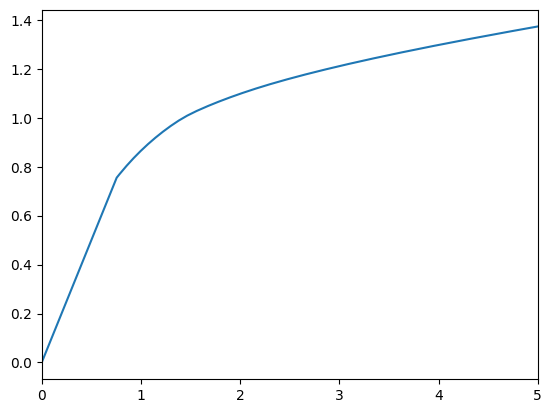

Marginal propensity to consume for an idiosyncratic shocks consumer type:


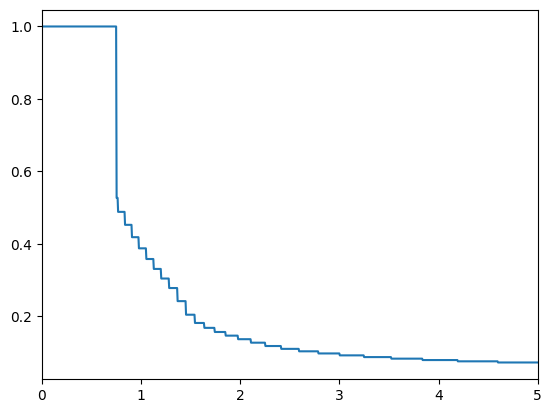

In [5]:
print("Consumption function for an idiosyncratic shocks consumer type:")
plot_funcs(IndShockExample.solution[0].cFunc, IndShockExample.solution[0].mNrmMin, 5)
print("Marginal propensity to consume for an idiosyncratic shocks consumer type:")
plot_funcs_der(
    IndShockExample.solution[0].cFunc,
    IndShockExample.solution[0].mNrmMin,
    5,
)

The lower part of the consumption function is linear with a slope of 1, representing the *constrained* part of the consumption function where the consumer *would like* to consume more by borrowing-- his marginal utility of consumption exceeds the marginal value of assets-- but he is prevented from doing so by the artificial borrowing constraint.

The MPC is a step function, as the $\texttt{cFunc}$ itself is a piecewise linear function; note the large jump in the MPC where the borrowing constraint begins to bind.

If you want to look at the interpolation nodes for the consumption function, these can be found by "digging into" attributes of $\texttt{cFunc}$:

The consumption function in this model is an instance of `LowerEnvelope1D`, a class that takes an arbitrary number of 1D interpolants as arguments to its initialization method.  When called, a `LowerEnvelope1D` evaluates each of its component functions and returns the lowest value.  Here, the two component functions are the *unconstrained* consumption function-- how the agent would consume if the artificial borrowing constraint did not exist for *just this period*-- and the *borrowing constrained* consumption function-- how much he would consume if the artificial borrowing constraint is binding.

The *actual* consumption function is the lower of these two functions, pointwise.  We can see this by plotting the component functions on the same figure:

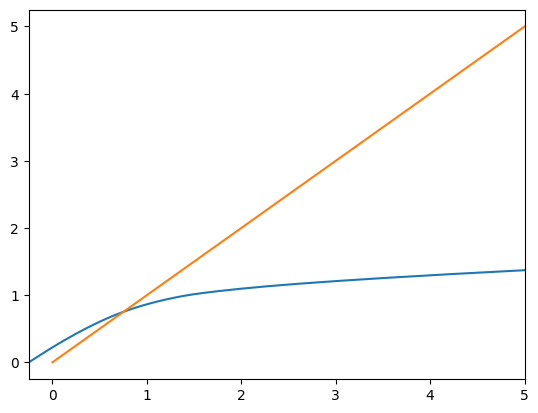

In [6]:
plot_funcs(IndShockExample.solution[0].cFunc.functions, -0.25, 5.0)